In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
import copy
import numpy as np

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
emnist_train = torchvision.datasets.EMNIST("../data", download=True, split="letters")
emnist_test = torchvision.datasets.EMNIST("../data", download=True, train=False, split="letters")

In [4]:
import torchvision.transforms as T
x = T.ToTensor()(emnist_train[0][0])
img_size = x.shape[-1]

In [5]:
train_data, train_labels = torch.zeros(len(emnist_train), 1, img_size, img_size), torch.zeros(len(emnist_train), 26)
trans = T.Compose([T.ToTensor()])
for i in range(len(emnist_train)):
    train_data[i,0,:,:] = trans(emnist_train[i][0])
    train_labels[i] = nn.functional.one_hot(torch.tensor(emnist_train[i][1] - 1), num_classes=26)

In [6]:
test_data, test_labels = torch.zeros(len(emnist_test), 1, img_size, img_size), torch.zeros(len(emnist_test), 26)
for i in range(len(emnist_test)):
    test_data[i,0,:,:] = trans(emnist_test[i][0])
    test_labels[i] = nn.functional.one_hot(torch.tensor(emnist_test[i][1] - 1), num_classes=26).long()

In [7]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(torch.Size([124800, 1, 28, 28]),
 torch.Size([124800, 26]),
 torch.Size([20800, 1, 28, 28]),
 torch.Size([20800, 26]))

In [8]:
test_labels[2000]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, batch_size=16, drop_last=True, shuffle=True)
test_loader = DataLoader(train_ds, batch_size=test_ds.tensors[0].shape[0])

In [10]:
def create_model():
    class EmnistNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1), # 28
                nn.ReLU(),
                nn.MaxPool2d(2), # 14
                nn.Conv2d(6, 10, 3, padding=1), # 14
                nn.ReLU(),
                nn.AvgPool2d(2), # 7
                nn.Flatten(),
                nn.Linear(10*7*7, 100),
                nn.ReLU(),
                nn.Linear(100, 26),
                nn.Softmax(dim=1)
            )
        def forward(self, x):
            return self.enc(x)
    net = EmnistNet()
    lossfunc = nn.CrossEntropyLoss()
    torch.nn.functional.softmax
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [11]:
net, lossfunc, _ = create_model()
x = torch.randn(5, 1, img_size, img_size)
y = net(x)
print(y.shape, y)
loss = lossfunc(y, torch.randn(5, 26))
print(loss)

torch.Size([5, 26]) tensor([[0.0396, 0.0409, 0.0389, 0.0369, 0.0364, 0.0350, 0.0396, 0.0364, 0.0372,
         0.0409, 0.0431, 0.0388, 0.0398, 0.0386, 0.0366, 0.0354, 0.0336, 0.0347,
         0.0385, 0.0457, 0.0373, 0.0377, 0.0405, 0.0378, 0.0408, 0.0393],
        [0.0404, 0.0407, 0.0401, 0.0356, 0.0354, 0.0340, 0.0411, 0.0356, 0.0373,
         0.0407, 0.0439, 0.0389, 0.0381, 0.0390, 0.0380, 0.0350, 0.0330, 0.0350,
         0.0383, 0.0459, 0.0371, 0.0392, 0.0408, 0.0374, 0.0414, 0.0384],
        [0.0406, 0.0407, 0.0398, 0.0351, 0.0350, 0.0339, 0.0395, 0.0354, 0.0382,
         0.0427, 0.0431, 0.0392, 0.0373, 0.0393, 0.0380, 0.0357, 0.0332, 0.0353,
         0.0399, 0.0451, 0.0364, 0.0386, 0.0413, 0.0382, 0.0408, 0.0378],
        [0.0400, 0.0410, 0.0396, 0.0355, 0.0356, 0.0346, 0.0408, 0.0346, 0.0377,
         0.0406, 0.0446, 0.0390, 0.0385, 0.0382, 0.0373, 0.0349, 0.0330, 0.0356,
         0.0388, 0.0459, 0.0363, 0.0386, 0.0405, 0.0381, 0.0415, 0.0392],
        [0.0407, 0.0423, 0.0391, 0.0

In [12]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
output.shape

torch.Size([2, 3])

In [19]:
epochs = 10

def train_model():
    net, lossfunc, optimizer = create_model()
    net.to(device=device)
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        batch_acc, batch_loss = [], []
        net.train()
        for x, y in train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*torch.mean((y_pred==y).float())
            batch_acc.append(acc.cpu().detach())
            batch_loss.append(loss.cpu().detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())
        
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            loss = lossfunc(y_test, y)
            test_loss.append(loss.item())
            test_acc.append(100*torch.mean((y_test==y).float()).item())
        print(f"Epoch {ei}, Train Loss: {train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train_acc: {train_acc[-1]:.2f}, Test_acc: {test_acc[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net

In [20]:
train_acc, test_acc, train_loss, test_loss, net = train_model()

Epoch 0, Train Loss: 3.14, Test Loss: 3.15, Train_acc: 81.19, Test_acc: 92.85
Epoch 1, Train Loss: 3.16, Test Loss: 3.15, Train_acc: 93.27, Test_acc: 93.33
Epoch 2, Train Loss: 3.15, Test Loss: 3.17, Train_acc: 93.45, Test_acc: 93.42
Epoch 3, Train Loss: 3.17, Test Loss: 3.14, Train_acc: 93.42, Test_acc: 93.55
Epoch 4, Train Loss: 3.17, Test Loss: 3.17, Train_acc: 93.39, Test_acc: 93.37
Epoch 5, Train Loss: 3.20, Test Loss: 3.19, Train_acc: 93.20, Test_acc: 93.25
Epoch 6, Train Loss: 3.20, Test Loss: 3.22, Train_acc: 93.23, Test_acc: 93.04
Epoch 7, Train Loss: 3.26, Test Loss: 3.22, Train_acc: 92.80, Test_acc: 93.04
Epoch 8, Train Loss: 3.20, Test Loss: 3.20, Train_acc: 93.21, Test_acc: 93.24
Epoch 9, Train Loss: 3.19, Test Loss: 3.20, Train_acc: 93.28, Test_acc: 93.20


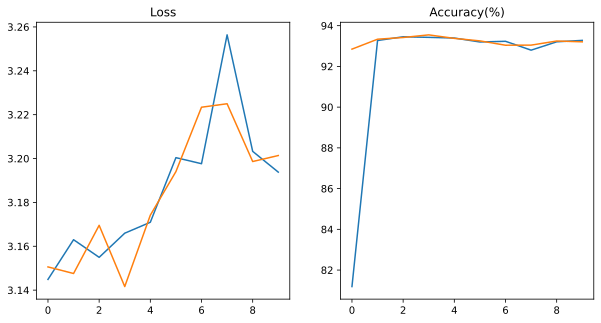

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(test_loss, label="Test Loss")
ax[0].set_title("Loss")

ax[1].plot(train_acc, label="Train Acc")
ax[1].plot(test_acc, label="Train Acc")
ax[1].set_title("Accuracy(%)")

plt.show()

## From Lecture

In [41]:
train_data, train_labels = torch.zeros(len(emnist_train), 1, img_size, img_size), torch.zeros(len(emnist_train), 1)
trans = T.Compose([T.ToTensor()])
for i in range(len(emnist_train)):
    train_data[i,0,:,:] = trans(emnist_train[i][0])
    train_labels[i] = emnist_train[i][1] - 1

In [42]:
test_data, test_labels = torch.zeros(len(emnist_test), 1, img_size, img_size), torch.zeros(len(emnist_test), 1)
trans = T.Compose([T.ToTensor()])
for i in range(len(emnist_test)):
    test_data[i,0,:,:] = trans(emnist_test[i][0])
    test_labels[i] = emnist_test[i][1] - 1

In [43]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(torch.Size([124800, 1, 28, 28]),
 torch.Size([124800, 1]),
 torch.Size([20800, 1, 28, 28]),
 torch.Size([20800, 1]))

In [44]:
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, batch_size=16, drop_last=True, shuffle=True)
test_loader = DataLoader(train_ds, batch_size=test_ds.tensors[0].shape[0])

In [45]:
def create_model():
    class EmnistNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1), # 28
                nn.ReLU(),
                nn.MaxPool2d(2), # 14
                nn.Conv2d(6, 10, 3, padding=1), # 14
                nn.ReLU(),
                nn.AvgPool2d(2), # 7
                nn.Flatten(),
                nn.Linear(10*7*7, 100),
                nn.ReLU(),
                nn.Linear(100, 26),
            )
        def forward(self, x):
            return self.enc(x)
    net = EmnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [47]:
net, lossfunc, _ = create_model()
x = torch.randn(5, 1, img_size, img_size)
y = net(x)
print(y.shape, y)
loss = lossfunc(y, torch.randn(5, 26))
print(loss)

torch.Size([5, 26]) tensor([[ 0.1232,  0.0020, -0.0304,  0.0826, -0.0384, -0.0242,  0.0341, -0.0847,
          0.0885,  0.0746, -0.1225,  0.0426,  0.1048,  0.0443, -0.0415,  0.0879,
         -0.0124, -0.0008, -0.1886, -0.1188,  0.0319, -0.0643, -0.0468,  0.0203,
          0.0541,  0.1895],
        [ 0.1251,  0.0295, -0.0517,  0.0854, -0.0265, -0.0276,  0.0322, -0.0905,
          0.1173,  0.0905, -0.0679,  0.0236,  0.1147,  0.0730, -0.0004,  0.0993,
          0.0147, -0.0432, -0.1888, -0.0676,  0.0052, -0.0784, -0.0191,  0.0289,
          0.0264,  0.1643],
        [ 0.1165,  0.0037, -0.0373,  0.0735, -0.0334, -0.0199,  0.0338, -0.0549,
          0.1063,  0.0752, -0.0798,  0.0408,  0.1192,  0.0279, -0.0293,  0.1259,
         -0.0056, -0.0652, -0.2031, -0.0693,  0.0199, -0.0706, -0.0101,  0.0481,
          0.0232,  0.1792],
        [ 0.1292,  0.0191, -0.0605,  0.0655, -0.0455, -0.0238,  0.0388, -0.1027,
          0.1128,  0.0588, -0.1016,  0.0511,  0.1430,  0.0355, -0.0053,  0.1168,
     

In [48]:
epochs = 10

def train_model():
    net, lossfunc, optimizer = create_model()
    net.to(device=device)
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        batch_acc, batch_loss = [], []
        net.train()
        for x, y in train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1)==y).float())
            batch_acc.append(acc.cpu().detach())
            batch_loss.append(loss.cpu().detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())
        
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            loss = lossfunc(y_test, y)
            test_loss.append(loss.item())
            test_acc.append(100*torch.mean((torch.argmax(y_test, axis=1)==y).float()).item())
        print(f"Epoch {ei}, Train Loss: {train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train_acc: {train_acc[-1]:.2f}, Test_acc: {test_acc[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net

In [49]:
train_acc, test_acc, train_loss, test_loss, net = train_model()

RuntimeError: 0D or 1D target tensor expected, multi-target not supported